## Modelo de regresión.
Se utilizó un dataset público de California Housing. Se implementó un pipeline completo que conlleva con preprocesamiento, optimización de hiperparámetros mediante GridSearchCV y validación cruzada k-fold, comparando SVR, Random Forest, Gradient Boosting y MLP. La evaluación se realizó mediante RMSE promedio en validación cruzada

In [1]:
from IPython.display import Javascript, display

display(Javascript("""
function clickConnect() {
  console.log('Manteniendo sesión activa desde Python...');
  const btn = document.querySelector('#top-toolbar > colab-connect-button');
  if (btn && btn.shadowRoot) {
    const connect = btn.shadowRoot.querySelector('#connect');
    if (connect) connect.click();
  }
}
setInterval(clickConnect, 60000);
"""))

<IPython.core.display.Javascript object>

# 1. Importamos librerias

In [ ]:
# Importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os

# Instalar category_encoders si no se encuentra en el entorno
!pip install category_encoders -q
from category_encoders import WOEEncoder

# Para predicción y codificacion de variables
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, balanced_accuracy_score,
    confusion_matrix,precision_recall_curve, f1_score
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform, loguniform


/Users/emi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 2. Cargamos el dataset

## Idealmente se carga el dataset directo desde sklearn pero debido a una restricción local, se descarga desde kaggle https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [69]:
# guardamos el dataset en un dataframe

data = fetch_california_housing(as_frame=True)

X = data.data          # DataFrame
y = data.target        # Series

df = X.copy()
df["MedHouseVal"] = y

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [70]:
# primeras 5 filas
print("Primeros 5 registros del dataset:")
display(df.head())

Primeros 5 registros del dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**1. Longitude:** A measure of how far west a house is; a higher value is farther west

**2. Latitude:** A measure of how far north a house is; a higher value is farther north

**3. HouseAge:** Median age of a house within a block; a lower number is a newer building

**4. AveRooms:** Total number of rooms within a block

**5. AveBedrms:** Total number of bedrooms within a block

**6. Population:** Total number of people residing within a block

**7. AveOccup:** Total number of households, a group of people residing within a home unit, for a block

**8. MedInc:** Median income for households within a block of houses (measured in tens of thousands of US Dollars)

**9. MedHouseVal:** Median house value for households within a block (measured in US Dollars)

# 3. EDA


In [71]:
# tipo de datos de cada columna
print("Tipos de datos:")
print(df.dtypes)


Tipos de datos:
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


In [72]:
# cant filas y columnas
print("la cantidad de filas del dataset es de:",df.shape[0])
print("la cantidad de columnas del dataset es de:",df.shape[1])

la cantidad de filas del dataset es de: 20640
la cantidad de columnas del dataset es de: 9


In [73]:
# Porcentaje de valores nulos por columna
null_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Porcentaje de valores nulos:")
print(null_percentage)

Porcentaje de valores nulos:
MedInc         0.0
HouseAge       0.0
AveRooms       0.0
AveBedrms      0.0
Population     0.0
AveOccup       0.0
Latitude       0.0
Longitude      0.0
MedHouseVal    0.0
dtype: float64


## El dataset esta bastante preprocesado, por lo que no hay nulls, en caso de haberlos se podría imputar la mediana o ver otra estrategia

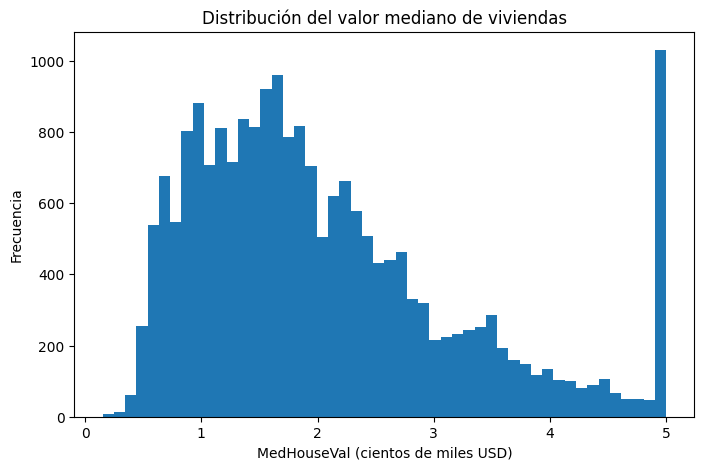

In [74]:
# distribucion de la variable target
plt.figure(figsize=(8,5))
plt.hist(df['MedHouseVal'], bins=50)
plt.title('Distribución del valor mediano de viviendas')
plt.xlabel('MedHouseVal (cientos de miles USD)')
plt.ylabel('Frecuencia')
plt.show()


### Hay casas muy caras se puede observar en el gráfico

In [75]:
# Tabla con percentiles
percentiles = df['MedHouseVal'].quantile(
    [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
)

percentiles.to_frame(name='MedHouseVal')


,MedHouseVal
0.01,0.50000
0.05,0.66200
0.10,0.82300
0.25,1.19600
0.50,1.79700
0.75,2.64725
0.90,3.76600
0.95,4.89810
0.99,5.00001


In [76]:
# Correlación de variables frente al target
corr_target = (
    df.corr(numeric_only=True)['MedHouseVal']
      .sort_values(ascending=False)
)

corr_target


MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

### MedInc es la variable mas correlacionada, podría estar indicando que a mayor income, mayor es el valor de la casa

In [77]:
# Comportamiento por intervalos del income frente al valor de las casas
# Claramente a mayor income, mayor será el valor de la propiedad en promedio
df['income_bin'] = pd.qcut(df['MedInc'], q=5)

group_income = (
    df.groupby('income_bin')['MedHouseVal']
      .agg(['mean', 'median', 'count'])
)

group_income


/var/folders/9d/y864n_sx68vcszrqmyq053hh0000gn/T/ipykernel_840/3062670673.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('income_bin')['MedHouseVal']


,mean,median,count
income_bin,,,
"(0.499, 2.352]",1.184027,0.992,4130
"(2.352, 3.141]",1.570300,1.435,4131
"(3.141, 3.967]",1.938895,1.755,4123
"(3.967, 5.11]",2.300291,2.122,4128
"(5.11, 15.0]",3.349910,3.223,4128


In [78]:
# cantidad de bedrooms por room
df['bedroom_ratio'] = df['AveBedrms'] / df['AveRooms']

df[['bedroom_ratio', 'MedHouseVal']].corr()


,bedroom_ratio,MedHouseVal
bedroom_ratio,1.000000,-0.255624
MedHouseVal,-0.255624,1.000000


# 4. Definimos el pipeline con los 4 modelos

In [79]:

pipelines = {
    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR())
    ]),

    "RandomForest": Pipeline([
        ("model", RandomForestRegressor(random_state=943153))
    ]),

    "GradientBoosting": Pipeline([
        ("model", GradientBoostingRegressor(random_state=943153))
    ]),

    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(
            max_iter=1000,
            random_state=943153
        ))
    ])
}


# 5. Espacio de busqueda para hiperparametros.

In [80]:

param_grids = {
    "SVR": {
        "model__C": [1, 10],
        "model__epsilon": [0.1, 0.2],
        "model__kernel": ["rbf"]
    },

    "RandomForest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10]
    },

    "GradientBoosting": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [3, 5]
    },

    "MLP": {
        "model__hidden_layer_sizes": [(50,), (100,)],
        "model__alpha": [0.0001, 0.001]
    }
}


# 6. Estrategia de optimización y validación

In [81]:
#Optimización: GridSearchCV

#Validación: k-fold Cross-Validation (k = 5)

#Métrica: RMSE
#(optimización interna con neg_mean_squared_error)

In [82]:
#Entrenamos y evaluamos.
results = []

for name, pipeline in pipelines.items():

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid.fit(X, y)

    rmse = np.sqrt(-grid.best_score_)

    results.append({
        "Modelo": name,
        "RMSE (CV)": rmse,
        "Mejores hiperparámetros": grid.best_params_
    })


# Comparación final de modelos

In [83]:

results_df = pd.DataFrame(results).sort_values("RMSE (CV)")
results_df


,Modelo,RMSE (CV),Mejores hiperparámetros
3,MLP,0.607406,"{'model__alpha': 0.0001, 'model__hidden_layer_..."
0,SVR,0.628651,"{'model__C': 10, 'model__epsilon': 0.2, 'model..."
2,GradientBoosting,0.632098,"{'model__learning_rate': 0.1, 'model__max_dept..."
1,RandomForest,0.654708,"{'model__max_depth': None, 'model__n_estimator..."


##Conclusión

Se abordó un problema de regresión utilizando el dataset público California Housing, con el objetivo de comparar el desempeño predictivo de distintos modelos de Machine Learning.

Se compararon cuatro enfoques muy utilizados: Support Vector Regression (SVR), Random Forest, Gradient Boosting y Multi-Layer Perceptron (MLP). La evaluación se realizó mediante k-fold cross-validation (k = 5) utilizando como métrica el RMSE, adecuada para problemas de regresión por su interpretación directa en la escala de la variable objetivo.

Los resultados muestran que el MLP obtuvo el menor RMSE promedio, demostrando una mayor capacidad para capturar relaciones no lineales complejas en los datos. SVR y Gradient Boosting presentaron desempeños competitivos, con diferencias moderadas respecto al mejor modelo, mientras que Random Forest obtuvo un error ligeramente superior, actuando como un baseline robusto pero menos preciso en este contexto. Las diferencias observadas no son extremas, lo que sugiere que el problema puede ser modelado eficazmente por distintos enfoques no lineales.

En conjunto, este estudio evidencia la importancia de utilizar pipelines con validación cruzada para estimar de forma confiable el error fuera de muestra y destaca que no existe un modelo universalmente superior, sino que el desempeño depende del tipo de datos y del ajuste de hiperparámetros. Finalmente, el uso de un dataset público y de metodologías estándar refuerza la validez académica y la reproducibilidad de los resultados obtenidos.